In [1]:
import sys
sys.version

import re
from konlpy.tag import Okt          
from konlpy.tag import Komoran
from collections import Counter
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from wordcloud import WordCloud

### 형태소 분석 및 품사 태깅 라이브러리
* https://konlpy.org/ko/v0.4.3/morph/#

## 한글 폰트 설정

In [2]:
font_path ="C:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
matplotlib.rc('font',family=font_name)

In [3]:
train = pd.read_csv('_data/train.csv', index_col=0)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   document  5000 non-null   object
 1   label     5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 117.2+ KB


In [4]:
test = pd.read_csv('_data/test.csv', index_col=0)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   document  5000 non-null   object
dtypes: object(1)
memory usage: 78.1+ KB


# 형태소 및 단어 분리
* 영어만으로 작성된 리뷰도 있기 때문에 문자열을 제외한 나머지를 공백으로 치환 (re.sub(r'[^\w]+', ' ', x)

In [13]:
komoran = Komoran()
okt = Okt()
def preprocessing(df):
    df['document'] = df.document.apply(lambda x : re.sub(r'[^\w]+', ' ', x))
    df['tokenized_stem'] = df.document.apply(lambda x : ' '.join(okt.morphs(x, stem=True)))
    df['nouns'] = df.document.apply(lambda x : komoran.nouns(x))
    
    nouns = []
    for s in df.nouns:
        words = [x for x in s if len(x)>1]
        nouns.append(' '.join(words))
    df['nouns'] = nouns
    
    token_pos = []
    for s in df.tokenized_stem:
        pos = komoran.pos(s)
        words = [x[0] for x in pos if (x[1] in ("VA", "VV")) & ((len(x[0]))>1)]

        token_pos.append(' '.join(words))
    df['token_pos']  = token_pos
    
    return df

In [14]:
train = preprocessing(train)
train.head()

,document,label,tokenized_stem,nouns,token_pos
id,,,,,
1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0,영상 이나 음악 이 이쁘다 해도 미화 시키다 불륜 일 뿐,영상 음악 미화 불륜,이쁘 시키
2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯,1,히치콕 이 이 영화 를 보다 분명 박수 를 치다,히치콕 영화 박수,
3,괜찮은 음악영화가 또 나왔군요 따뜻한 겨울이 될 것 같아요,1,괜찮다 음악 영화 가 또 나오다 따뜻하다 겨울 이 되다 것 같다,음악 영화 겨울,괜찮 나오
4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0,아무래도 20년 도지난작품이라 지금 보기 는 너무 유치하다,년대 지난 작품 지금 보기 유치,
5,지금까지의 영화들이 그랬듯 이 영화역시 일본에 대한 미화는 여전하다,0,지금 까지의 영화 들 이 그렇다 이 영화 역시 일본 에 대한 미화 는 여전하다,지금 영화 영화 일본 미화,그렇 대하


In [15]:
train.tail()

,document,label,tokenized_stem,nouns,token_pos
id,,,,,
4996,좋은 배우들로 3류영화를 찍은 안타까운 영화,0,좋다 배우 들 로 3 류 영화 를 찍다 안타깝다 영화,배우 영화 영화,안타깝
4997,진짜 드럽게 재미없다 에드워드 호퍼 그림에 배경 빼고는 볼게 아닌영화,0,진짜 드럽다 재미없다 에드워드 호퍼 그림 에 배경 빼다 볼 게 아니다 영화,에드워드 호퍼 그림 배경 영화,드럽 재미없
4998,가장 실망스러운 영화 지금까지 본영화중,0,가장 실망 스러운 영화 지금 까지 본 영화 중,실망 영화 지금 영화,
4999,이런 평점 테러 네이버에서 좀 막아야 하는 것 아닌가,1,이렇다 평점 테러 네이버 에서 좀 막다 하다 것 아니다,평점 테러 네이버,이렇
5000,여주인공이 전작에서는 귀여웠는데 여기선 완전 망했네 실망이다,0,여 주인공 이 전작 에서는 귀엽다 여 기선 완전 망하다 실망 이다,여주인공 전작 완전 실망,귀엽 망하


In [19]:
strings = []
for s in train[train.label==1].nouns:
    strings+= s.split()
p_cnt = Counter(strings)

In [21]:
strings = []
for s in train[train.label==0].nouns:
    strings+= s.split()
n_cnt = Counter(strings)

In [25]:
def visualize(noun_list, title):
    # 워드클라우드 이미지 생성
    wc= WordCloud(
        font_path = font_path,    # 한글폰트 경로 설정
        background_color='white',                             # 배경 색깔 정하기
        colormap = 'Dark2',                                # 폰트 색깔 정하기
        width = 800,
        height = 800).generate_from_frequencies(dict(noun_list)) 
    
    plt.figure(figsize=(10,10)) #이미지 사이즈 지정
    plt.suptitle("Word Cloud", fontsize=40)
    plt.title(title, fontsize=20)
    plt.imshow(wc, interpolation='lanczos') #이미지의 부드럽기 정도
    plt.axis('off') #x y 축 숫자 제거
    plt.show()  # 워드클라우드 이미지 확인
    
    return wc

In [36]:
positives = {}
for key, value in p_cnt.items():
    if key not in n_cnt.keys():
        positives[key]= value

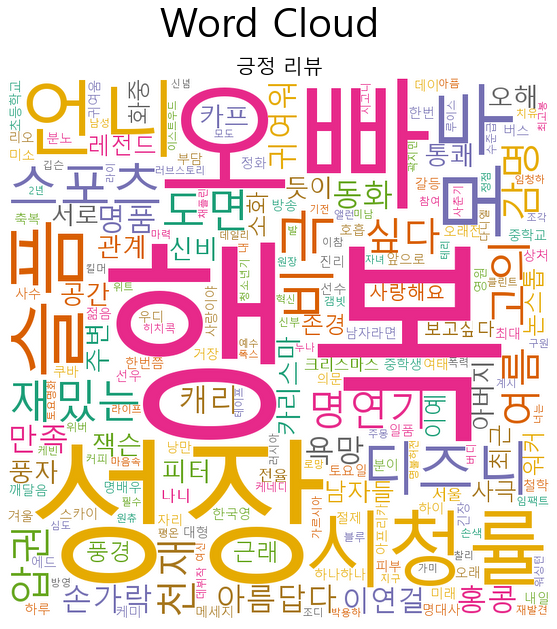

In [37]:
visualize(positives, '긍정 리뷰')

In [38]:
negatives = {}
for key, value in n_cnt.items():
    if key not in p_cnt.keys():
        negatives[key]= value

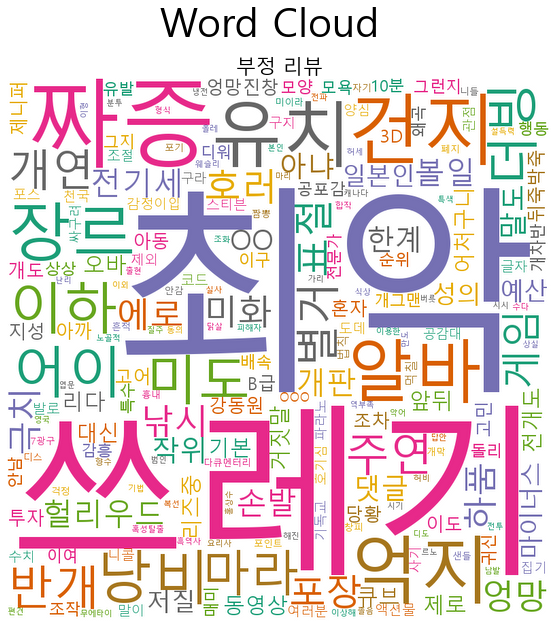

In [40]:
visualize(negatives, '부정 리뷰')

# 긍/부정 token pos 시각화

In [52]:
token_pos_p = []
for s in train[train.label==1].token_pos:
    token_pos_p+= s.split()
p_pos = Counter(token_pos_p)

In [53]:
token_pos_n = []
for s in train[train.label==0].token_pos:
    token_pos_n+= s.split()
n_pos = Counter(token_pos_n)

In [54]:
t_pos_p = {}
for key, value in p_pos.items():
    if key not in n_pos.keys():
        t_pos_p[key]= value

In [55]:
t_pos_n = {}
for key, value in n_pos.items():
    if key not in p_pos.keys():
        t_pos_n[key]= value

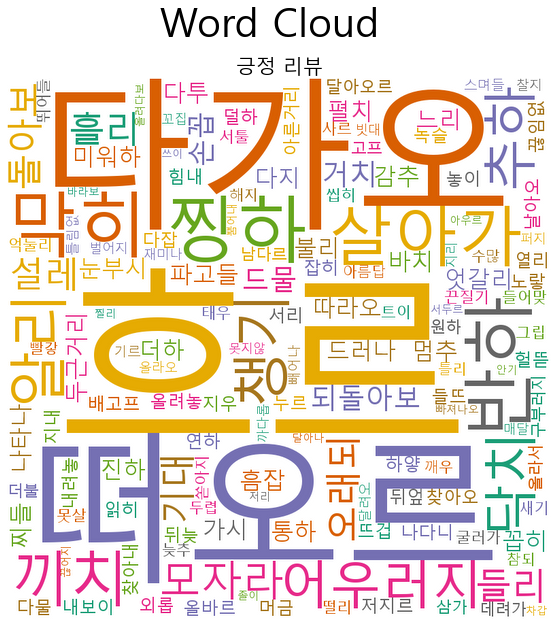

In [56]:
visualize(t_pos_p, '긍정 리뷰')

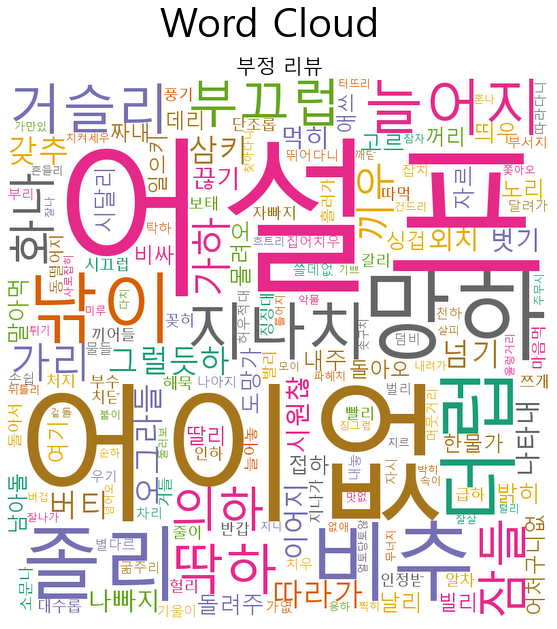

In [57]:
visualize(t_pos_n, '부정 리뷰')

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold , KFold
from sklearn.linear_model import LogisticRegression #모델 불러오기
import numpy as np
SEED=32

In [92]:
train_df = train.loc[:, ['nouns', 'label']].reset_index()
train_df

,id,nouns,label
0,1,영상 음악 미화 불륜,0
1,2,히치콕 영화 박수,1
2,3,음악 영화 겨울,1
3,4,년대 지난 작품 지금 보기 유치,0
4,5,지금 영화 영화 일본 미화,0
...,...,...,...
4995,4996,배우 영화 영화,0
4996,4997,에드워드 호퍼 그림 배경 영화,0
4997,4998,실망 영화 지금 영화,0
4998,4999,평점 테러 네이버,1


In [ ]:
# 교집합 제거..

In [98]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
scores = []
for t_index, v_index in cv.split(train_df):
    X = train_df['nouns']
    y = train_df['label']
    
    X_train = X.loc[t_index]
    y_train = y[t_index]
    X_val = X.loc[v_index]
    y_val = y[v_index]
    tfidf = TfidfVectorizer(analyzer="char", ngram_range=(1, 3))
    tfidf.fit(X_train) # countvectorizer 학습
    X_train_vec = tfidf.transform(X_train) # transform
    
    model = SVC() #객체에 모델 할당
    model.fit(X_train_vec, y_train) #모델 학습
    
    X_val_vec = tfidf.transform(X_val) 
    y_pred = model.predict(X_val_vec)
    score = accuracy_score(y_val, y_pred)
    scores.append(score)
print(scores)
print(np.mean(scores))

[0.691, 0.721, 0.72, 0.719, 0.739]
0.7179999999999999


In [ ]:
#train.token_pos

In [9]:
test = preprocessing(test)
test.head()

,document,tokenized_stem,nouns,token_pos
id,,,,
1,시간 때우기 좋은 영화 지루함,시간 때우다 좋다 영화 지루함,,때우
2,훈훈한 정이 느껴지는 영화 가족끼리 드라마 보듯이 보면 딱,훈훈하다 정이 느껴지다 영화 가족 끼리 드라마 보다 보다 딱,,느끼
3,Childhood fantasy,Childhood fantasy,,
4,멋있는 영화입니다 잊을 수 없는,멋있다 영화 이다 잊다 수 없다,,멋있
5,너무 감동적이네요 펑펑 울었습니다,너무 감동 적다 펑펑 울다,,


In [10]:
positive = train[train.label==1]
positive.tail()

,document,label,tokenized_stem,nouns,token_pos
id,,,,,
4989,저 덕심 쥐뿔도 없지만 정말 재미있었어요,1,저 덕심 쥐뿔 도 없다 정말 재미있다,,재미있
4990,진짜재미있었다 조금지그러웠지만역시이토준지씨이다,1,진짜 재미있다 조 금지 그렇다 웠 지만 역시 이토준지 씨 이다,,재미있 그렇
4993,아 오랜 기다림끝에 드디어 보게 되네요 최고입니다,1,아 오랜 기다림 끝 에 드디어 보다 되다 최고 이다,,기다리
4994,고난도의 심리 묘사가 표현된 최고의 영화,1,고난 도의 심리 묘사 가 표현 되다 최고 의 영화,,
4999,이런 평점 테러 네이버에서 좀 막아야 하는 것 아닌가,1,이렇다 평점 테러 네이버 에서 좀 막다 하다 것 아니다,,이렇


In [11]:
negative = train[train.label==0]
negative.tail()

,document,label,tokenized_stem,nouns,token_pos
id,,,,,
4995,도대체 누가 안소니짐머라는거지,0,도대체 누가 안소니 짐머 라는 거지,,
4996,좋은 배우들로 3류영화를 찍은 안타까운 영화,0,좋다 배우 들 로 3 류 영화 를 찍다 안타깝다 영화,,안타깝
4997,진짜 드럽게 재미없다 에드워드 호퍼 그림에 배경 빼고는 볼게 아닌영화,0,진짜 드럽다 재미없다 에드워드 호퍼 그림 에 배경 빼다 볼 게 아니다 영화,,드럽 재미없
4998,가장 실망스러운 영화 지금까지 본영화중,0,가장 실망 스러운 영화 지금 까지 본 영화 중,,
5000,여주인공이 전작에서는 귀여웠는데 여기선 완전 망했네 실망이다,0,여 주인공 이 전작 에서는 귀엽다 여 기선 완전 망하다 실망 이다,,귀엽 망하
